In [293]:
import pathlib

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdDistGeom
import torch
from mace.calculators import mace_off
import numpy as np

import ase
import ase.io as aio
from ase import units as ase_units
from ase.visualize import view
from ase.optimize import FIRE
from ase.md import Langevin
import pandas as pd
from simgen.calculators import MaceSimilarityCalculator

In [304]:
ref_atoms = aio.read("penicillin_analogues.xyz", index=":")
# ref_atoms = [a[a.numbers!=1] for a in ref_atoms]
core_ids = np.load("penicillin_core_ids.npy")

In [305]:
core_ids[0,2]

2

In [306]:
len(core_ids) == len(ref_atoms)

True

In [307]:
calc = mace_off("medium", device="cuda", default_dtype="float32")

Using MACE-OFF23 MODEL for MACECalculator with /home/rokas/.cache/mace/MACE-OFF23_medium.model
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


/home/rokas/miniconda3/envs/genesis/lib/python3.12/site-packages/mace/calculators/mace.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_path, map_loc

In [308]:
z_table = calc.z_table
core_atom_masks = []
for atoms, mask in zip(ref_atoms, core_ids, strict=True):
    core_atom_mask = np.zeros(len(atoms), dtype=bool)
    core_atom_mask[mask] = True
    core_atom_masks.append(core_atom_mask)

In [309]:
element_sigma_array = (
        np.ones_like(z_table.zs, dtype=np.float32) * 0.7
    )
element_sigma_array[z_table.z_to_index(7)] = 1.
element_sigma_array[z_table.z_to_index(16)] = 1.
sim_calc = MaceSimilarityCalculator(
    model=calc.models[0],
    reference_data=ref_atoms,
    ref_data_mask=core_atom_masks,
    element_sigma_array=element_sigma_array,
    max_norm=None,
    device="cuda",
)

In [310]:
from torch_scatter import scatter_logsumexp

In [219]:
# read sdf files
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt

In [220]:
# sdf_path = pathlib.Path("./results_inverse_summation/exp_1/SDF")
# sdf_files = list(sdf_path.glob("*.sdf"))
# mols = []
# original_indices = []
# for sdf_file in sdf_files:
#     suppl = Chem.SDMolSupplier(str(sdf_file))
#     original_indices.append(int(sdf_file.stem.split("_")[-1]))
#     for mol in suppl:
#         if mol is not None:
#             mols.append(mol)
#         else:
#             print(f"Failed to read {sdf_file}")
#             mols.append(None)

In [221]:
with open("./SMILES.txt", "r") as f:
    smiles = f.readlines()
    mols = [Chem.MolFromSmiles(smi) for smi in smiles]

In [222]:
atom_to_eval = aio.read("./last_frames.xyz", index=":")

In [223]:
len(mols) == len(atom_to_eval)

True

In [224]:
penicillin_core_mol = Chem.MolFromSmiles("O=C1CC2N1CCS2")
lactam_patt = Chem.MolFromSmarts("O=C1NCC1")
thio_ring_patt = Chem.MolFromSmarts("[*]1[#16][*][*][*]1")
thio_ring_strict = Chem.MolFromSmarts("[*]1[#16][*][#7][*]1")

In [225]:
has_lactam = [mol.HasSubstructMatch(lactam_patt) for mol in mols]
has_thio_ring = [mol.HasSubstructMatch(thio_ring_patt) for mol in mols]
has_thio_ring_strict = [mol.HasSubstructMatch(thio_ring_strict) for mol in mols]
has_both = [x and y for x, y in zip(has_lactam, has_thio_ring)]
has_both_strict = [x and y for x, y in zip(has_lactam, has_thio_ring_strict)]

In [226]:
def rdkit_mol_2_ase(mol):
    symbols = [atom.GetSymbol() for atom in mol.GetAtoms()]
    positions = mol.GetConformer().GetPositions()
    return ase.Atoms(symbols, positions)

In [227]:
@torch.no_grad()
def calculate_log_dens(sim_calc, atoms_list, noise_level=1.):
    batch = sim_calc.batch_atoms(atoms_list)
    embeddings = sim_calc._get_node_embeddings(batch)
    squared_distance_matrix = sim_calc._calculate_distance_matrix(embeddings, batch.node_attrs)
    additional_multiplier = 119 * (1 - (noise_level / 10) ** 0.25) + 1 if noise_level <= 10 else 1
    # additional_multiplier = 1/(noise_level**0.5)
    squared_distance_matrix = squared_distance_matrix * additional_multiplier # (N_config_atoms, N_ref_atoms)
    log_dens = scatter_logsumexp(-squared_distance_matrix / 2, batch.batch, dim=0) # (N_graphs, N_ref_atoms)
    log_dens = log_dens.sum(dim=-1) # (N_graphs,)
    return log_dens

In [262]:
calculate_log_dens(sim_calc, ref_atoms, noise_level=0.005)

tensor([112.2837, 103.8965, 106.0739, 116.3486, 141.1951, 112.9837, 114.2169,
        106.8756, 108.8365, 108.0037, 107.8456, 122.2193,  90.8475, 147.6924,
        117.3693,  99.3267, 103.4424, 104.7689, 157.3490, 118.4723, 122.0900,
        123.5182], device='cuda:0')

In [263]:
generated_densities = np.zeros((len(atom_to_eval)))
batch_size = 32
noise_level = 0.005
for start_idx in range(0, len(atom_to_eval), batch_size):
    end_idx = min(start_idx+batch_size, len(atom_to_eval))
    atoms_batch = atom_to_eval[start_idx:end_idx]
    log_dens = calculate_log_dens(sim_calc, atoms_batch, noise_level=noise_level)
    generated_densities[start_idx:end_idx] = log_dens.detach().cpu().numpy()

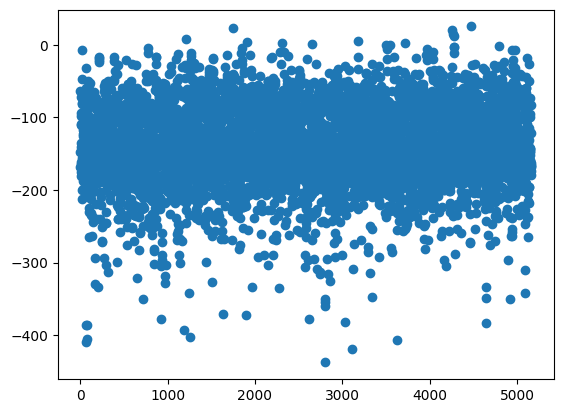

In [264]:
plt.scatter(np.arange(len(atom_to_eval)), generated_densities)

In [265]:
def show_atom_number(mol, label):
    for atom in mol.GetAtoms():
        atom.SetProp(label, str(atom.GetIdx()))
    return mol

In [266]:
np.argsort(has_both_strict)

array([   0, 3445, 3444, ..., 1338, 3763,  866])

Density: -17.50332260131836


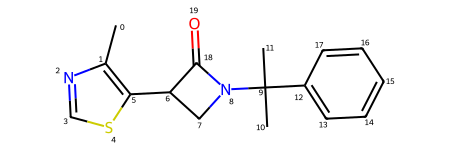

In [267]:
idx = 866
print(f"Density: {generated_densities[idx]}")
show_atom_number(mols[idx], "atomNote")

Density: -16.774816513061523


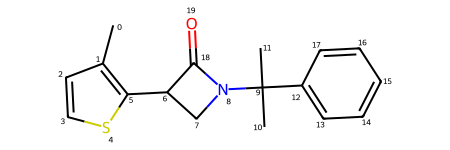

In [268]:
idx = 868
print(f"Density: {generated_densities[idx]}")
show_atom_number(mols[idx], "atomNote")

In [269]:
np.argsort(generated_densities)[-10:]

array([2306, 3718, 1913, 3184, 1207, 4281, 4263, 4260, 1748, 4477])

In [37]:
np.argsort(generated_densities)[-10:]

array([4260, 2906, 1852, 4262, 1720,  865,  868, 3966, 1519, 5111])

Density: 2.6023519039154053


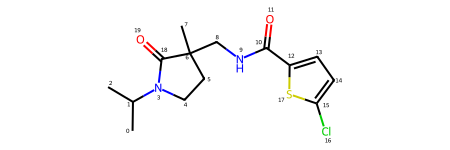

In [278]:
idx = 2306
print(f"Density: {generated_densities[idx]}")
show_atom_number(mols[idx], "atomNote")

In [101]:
ref_embeddings = sim_calc.reference_embeddings.detach().cpu().numpy()
ref_embeddings = ref_embeddings.reshape(-1, 8, 128)

In [145]:
emb1 = sim_calc._get_node_embeddings(sim_calc.batch_atoms([atom_to_eval[866]])).detach().cpu().numpy()
emb2 = sim_calc._get_node_embeddings(sim_calc.batch_atoms([atom_to_eval[4260]])).detach().cpu().numpy()

In [103]:
diff[5]

array([4.2800438e-01, 2.5056581e+00, 5.2671056e+00, 2.4326115e+00,
       2.1850684e+00, 1.3282039e-03, 3.2061487e-01, 7.6414323e-01,
       1.1507253e+01, 3.0175132e-01, 7.9427799e-03, 3.5448432e+00,
       7.5678344e+00, 3.9532065e+00, 7.2461823e-03, 6.5598631e+00,
       1.3812872e+00, 3.5786731e+00, 3.8766654e+00, 4.3970056e+00],
      dtype=float32)

In [104]:
diff[6]

array([5.9334817, 4.171363 , 4.513203 , 6.270825 , 7.3784103, 5.882595 ,
       5.7306767, 5.833955 , 5.694849 , 5.8440733, 5.9763174, 7.6652474,
       1.5031472, 8.870562 , 5.9394407, 1.8291779, 6.940359 , 8.324114 ,
       4.773965 , 8.029644 ], dtype=float32)

In [105]:
diff = ((emb1[:, None] - emb2[None, :])**2).sum(axis=-1)
diff.shape

(20, 20)

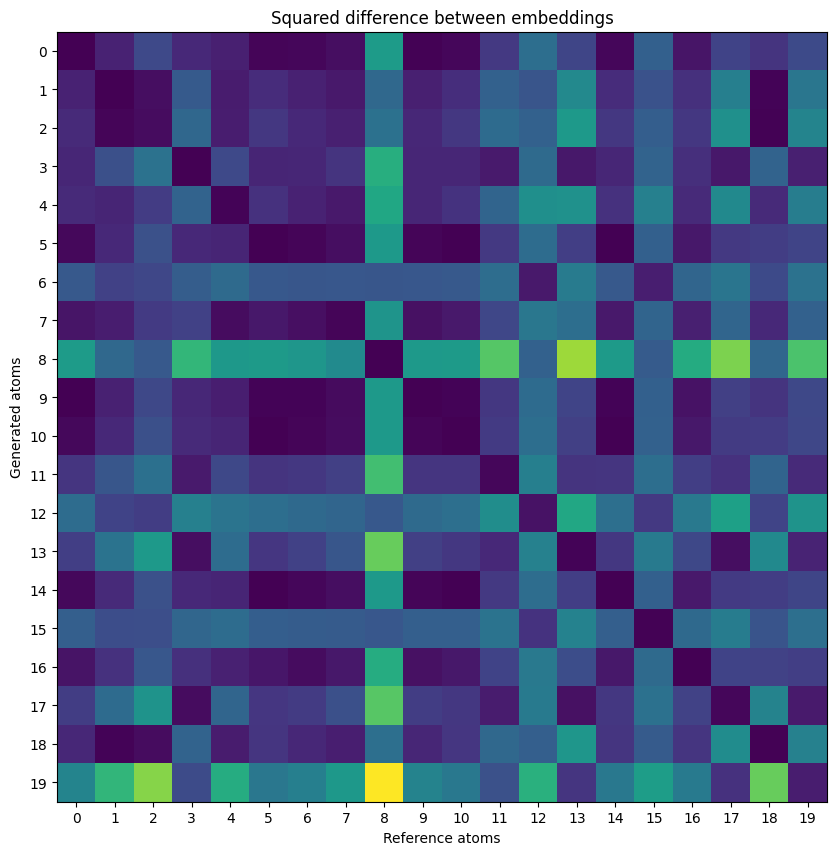

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(diff)
ax.set(
    title="Squared difference between embeddings",
    xlabel="Reference atoms",
    ylabel="Generated atoms",
    xticks=np.arange(20),
    yticks=np.arange(20),
)
pass

In [166]:
diff1_with_ref = ((emb1[:, None] - ref_embeddings[0][None, :])**2).sum(axis=-1)
diff2_with_ref = ((emb2[:, None] - ref_embeddings[0][None, :])**2).sum(axis=-1)
noise_level = 1
# additional_multiplier = 119 * (1 - (noise_level / 10) ** 0.25) + 1 if noise_level <= 10 else 1
additional_multiplier = 1
kernel1 = np.exp(-(diff1_with_ref / 2) * additional_multiplier)
kernel2 = np.exp(-(diff2_with_ref / 2) * additional_multiplier)

In [167]:
both_max = np.maximum(kernel1, kernel2)
both_min = np.minimum(kernel1, kernel2)
cmap = plt.get_cmap("plasma")
norm = plt.Normalize(both_min.min(), both_max.max())

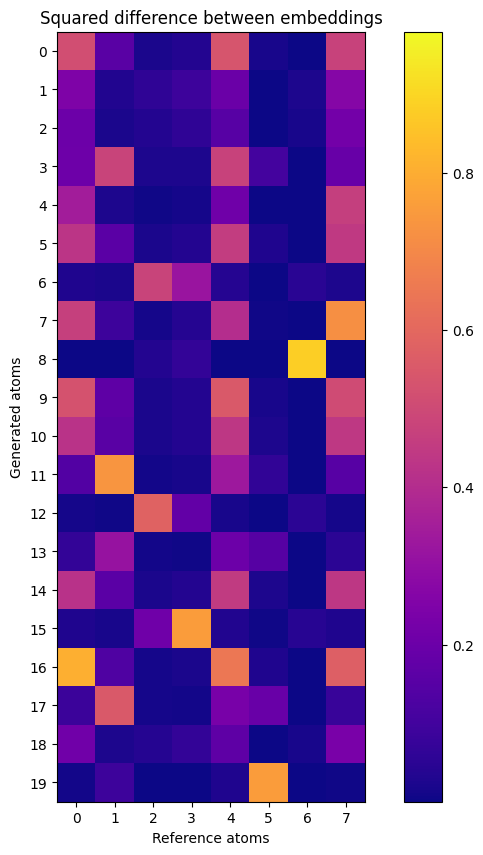

In [168]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
im = ax.imshow(kernel1, 
               cmap=cmap,
               norm=norm) 
ax.set(
    title="Squared difference between embeddings",
    xlabel="Reference atoms",
    ylabel="Generated atoms",
    xticks=np.arange(8),
    yticks=np.arange(20),
)
plt.colorbar(im, ax=ax)
pass

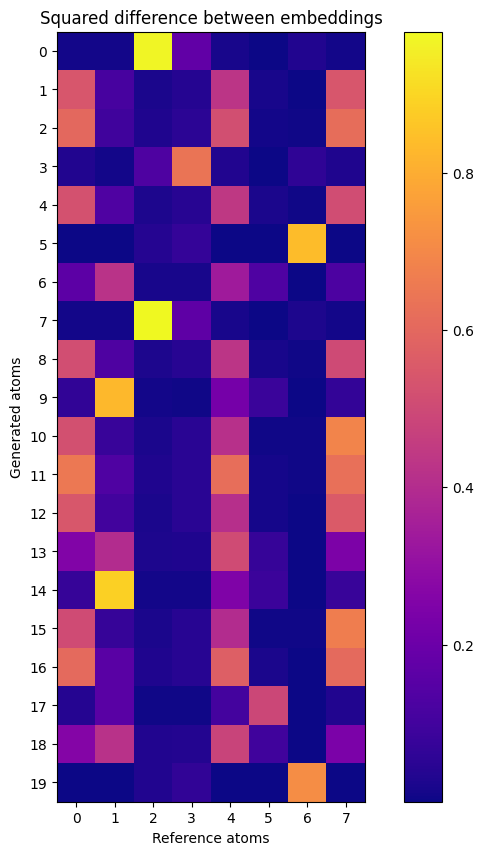

In [170]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
im = ax.imshow(kernel2, 
               cmap=cmap,
               norm=norm) 
ax.set(
    title="Squared difference between embeddings",
    xlabel="Reference atoms",
    ylabel="Generated atoms",
    xticks=np.arange(8),
    yticks=np.arange(20),
)
plt.colorbar(im, ax=ax)
pass

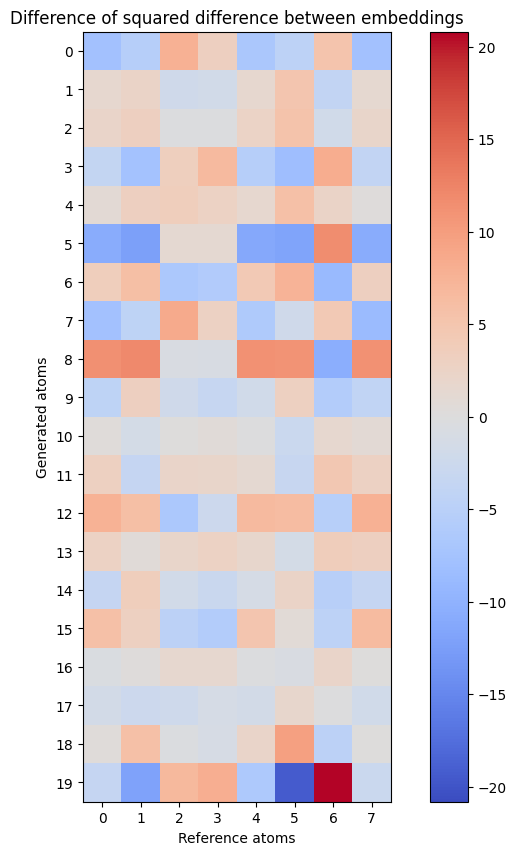

In [172]:
difference_of_diff = diff1_with_ref - diff2_with_ref
cmap = plt.get_cmap("coolwarm")
symmetric_norm = plt.Normalize(-np.abs(difference_of_diff).max(), np.abs(difference_of_diff).max())

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
im = ax.imshow(difference_of_diff, 
               cmap=cmap,
               norm=symmetric_norm)
ax.set(
    title="Difference of squared difference between embeddings",
    xlabel="Reference atoms",
    ylabel="Generated atoms",
    xticks=np.arange(8),
    yticks=np.arange(20),
)
plt.colorbar(im, ax=ax)
pass